<a href="https://colab.research.google.com/github/Murad0998/statistics-project/blob/main/notebooks/04_ab_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Полный EDA
===

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv('data_ab.csv')

# 1. структура данных, проводим EDA и выбраем метрику, с которой будем работать


In [ ]:
display(df.head())

display(df.info())

print(df.shape[0], df.shape[1])

display(df.describe())

display(df.isnull().sum())


for col in df.columns:
    if col != 'user_id' and col != 'timestamp':
        print(f"{col}: {df[col].unique()}")


print(len(df))
print(df['user_id'].nunique())
print(len(df) - df['user_id'].nunique())

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


None

294478 5


,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


group: ['control' 'treatment']
landing_page: ['old_page' 'new_page']
converted: [0 1]
294478
290584
3894


Размер датасета:
- Строк: 294478, Столбцов: 5

Уникальные значения по столбцам:
- group: ['control' 'treatment']
- landing_page: ['old_page' 'new_page']
- converted: [0 1]
- Всего записей: 294478
- Уникальных пользователей: 290584
- Количество не уникальных айдишников: 3894

Пропусков нет

4 колонки:
- user_id - 294478 -  int64
- timestamp   -  294478  - object
- group     -    294478 -  object
- landing_page - 294478 - object
- converted - 294478 - int64

In [ ]:
display(df['group'].value_counts())

display(df['landing_page'].value_counts())

display(df['converted'].value_counts())

print(df['converted'].mean())

,count
group,
treatment,147276
control,147202


,count
landing_page,
old_page,147239
new_page,147239


,count
converted,
0,259241
1,35237


0.11965919355605512


Распределение по группам:
- treatment	- 147276
- control	- 147202


Распределение по страницам:

- old_page	- 147239
- new_page - 147239


Распределение converted:

- 0	- 259241
- 1	- 35237


Общая конверсия: 0.1197 или 11.97%

In [ ]:
display(df[df['group'] == 'control']['landing_page'].value_counts())

display(df[df['group'] == 'treatment']['landing_page'].value_counts())

wrong_control = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')]
wrong_treatment = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]

print(len(wrong_control))
print(len(wrong_treatment))
print(len(wrong_control) + len(wrong_treatment))

,count
landing_page,
old_page,145274
new_page,1928


,count
landing_page,
new_page,145311
old_page,1965


1928
1965
3893


Проверка соответствия group и landing_page:

Control группа:


- old_page	- 145274
- new_page	- 1928



Treatment группа:

- new_page	- 145311
- old_page	- 1965


Ошибок в control (показали new_page): 1928

Ошибок в treatment (показали old_page): 1965

Всего неправильных соответсвий: 3893

In [ ]:
print(f"Всего записей: {len(df)}")
print(f"Уникальных пользователей: {df['user_id'].nunique()}")
print(f"Дубликатов: {len(df) - df['user_id'].nunique()}")


duplicate_users = df[df.duplicated(subset='user_id', keep=False)]
print(duplicate_users['user_id'].nunique())


users_groups = df.groupby('user_id')['group'].unique()
users_in_both = users_groups[users_groups.apply(len) > 1]

print(len(users_in_both))


Всего записей: 294478
Уникальных пользователей: 290584
Дубликатов: 3894
3894
1895


Всего записей: 294478

Уникальных пользователей: 290584

Дубликатов (записей): 3894

Проблема есть! Эти пользователи видели обе версии страницы!

In [ ]:
df_step1 = df[~(
    ((df['group'] == 'control') & (df['landing_page'] == 'new_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')))]

removed_step1 = len(df) - len(df_step1)
print(f"Удалено записей: {removed_step1}")
print(f"Осталось записей: {len(df_step1)}")


users_groups = df_step1.groupby('user_id')['group'].unique()
users_in_both = users_groups[users_groups.apply(len) > 1]

print(f"Загрязнённых пользователей: {len(users_in_both)}")



print(f"Уникальных пользователей: {df_step1['user_id'].nunique()}")

df_clean = df_step1.drop_duplicates(subset='user_id', keep='first')

removed_step3 = len(df_step1) - len(df_clean)

print(f"Удалено повторных визитов: {removed_step3}")



print(f"Всего записей: {len(df_clean)}")
print(f"Уникальных user_id: {df_clean['user_id'].nunique()}")


users_groups_clean = df_clean.groupby('user_id')['group'].unique()
users_in_both_clean = users_groups_clean[users_groups_clean.apply(len) > 1]
print(len(users_in_both_clean))


group_counts = df_clean['group'].value_counts()
display(group_counts)



Удалено записей: 3893
Осталось записей: 290585
Загрязнённых пользователей: 0
Уникальных пользователей: 290584
Удалено повторных визитов: 1
Всего записей: 290584
Уникальных user_id: 290584
0


,count
group,
treatment,145310
control,145274


Процесс очистки:

**Шаг 1: Удаление неправильных соответствий**
- Удалено: 3,893 записи
- Причина: несоответствие group - landing_page
- Автоматически устранено загрязнение между группами

**Шаг 2: Проверка загрязнения**
- Проверено: нет пользователей в обеих группах
- Результат: 0 загрязнённых пользователей

**Шаг 3: Удаление повторных визитов**
- Стратегия: оставлен **первый визит** каждого пользователя (keep='first')
  - Первое впечатление определяет решение о конверсии
- Удалено: 1 повторный визит

### Итоговый чистый датасет:

**290,584 уникальных пользователей**
- Control: 145,310
- Treatment: 145,274
- Разница: 36 пользователей (0.01%)


Обнаруженные проблемы:

1. Неправильные соответствия group - landing_page:
- Control получили new_page: 1,928 записей
- Treatment получили old_page: 1,965 записей
- Всего: 3,893 записи


2. Повторные визиты (дубликаты):
- Всего записей в датасете: 294,478
- Уникальных пользователей: 290,584
- Повторных визитов: 3,894 записи
- **Пользователей с дубликатами:** 3,894


Важно: Проблемы 1 и 2 — это независимые проблемы с разной природой.

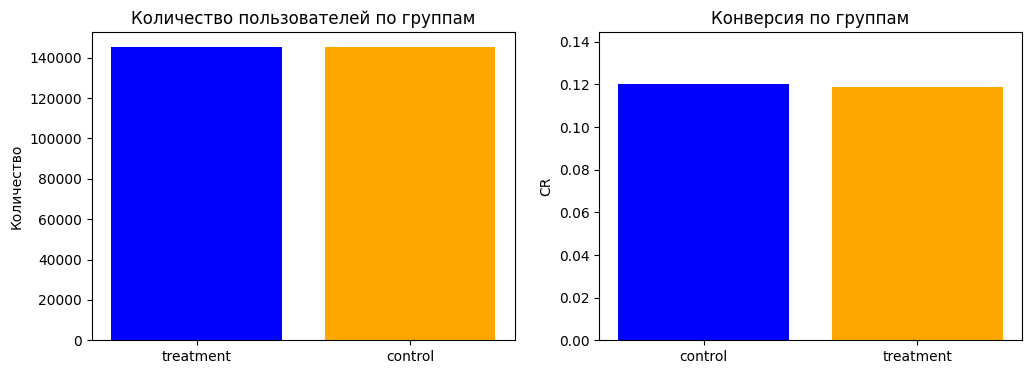

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

group_counts = df_clean['group'].value_counts()
ax[0].bar(group_counts.index, group_counts.values, color=['blue', 'orange'])
ax[0].set_title('Количество пользователей по группам')
ax[0].set_ylabel('Количество')


conversion_by_group = df_clean.groupby('group')['converted'].mean()
ax[1].bar(conversion_by_group.index, conversion_by_group.values, color=['blue', 'orange'])
ax[1].set_title('Конверсия по группам')
ax[1].set_ylabel('CR')
ax[1].set_ylim(0, max(conversion_by_group.values) * 1.2)



plt.show()

In [ ]:
for group in ['control', 'treatment']:
    conv = df_clean[df_clean['group'] == group]['converted'].mean()
    n = len(df_clean[df_clean['group'] == group])
    print(group, conv, n)


df_clean.to_csv('data_ab_clean.csv', index=False)

control 0.1203863045004612 145274
treatment 0.11880806551510564 145310


Конверсия по группам:
- control: 0.1204 (n=145274)
- treatment: 0.1188 (n=145310)

Метрика для анализа: Conversion Rate (CR)

CR = количество конвертированных / общее количество пользователей

Почему:

- Целевое действие - регистрация на курс (бинарный признак)

- Метрика напрямую отражает бизнес-цель

- Легко интерпретируется

- Подходит для статистических тестов (z-test)

Бизнес-вывод по результатам предварительного анализа A/B теста

Ключевые находки:

На основе проведенного исследовательского анализа данных A/B-тестирования новой версии лендинга с участием 290 584 уникальных пользователей выявлено следующее:

Новая версия страницы (treatment) показала конверсию 11,88%, что на 0,16 процентных пунктов ниже, чем конверсия старой версии (control) — 12,04%. В абсолютных числах это означает, что из каждой тысячи пользователей старая страница конвертирует на 1-2 человека больше.
Рекомендация для бизнеса:

На данном этапе не рекомендуется внедрять новую версию лендинга в продакшн. Несмотря на равномерное распределение пользователей между группами (145 274 vs 145 310), новая страница демонстрирует негативную динамику.

---
# 2. проверяем корректность проведения тестирования (посмотрим на однородность групп, задумаемся об A/A тесте


In [ ]:
df = pd.read_csv('data_ab_clean.csv')


In [ ]:
control = df[df['group'] == 'control']
treatment = df[df['group'] == 'treatment']

print(len(control))
print(len(treatment))
print(abs(len(control) - len(treatment)))
print(abs(len(control) - len(treatment)) / len(df))

145274
145310
36
0.00012388844533766483


Размеры групп:
- Размер control: 145274
- Размер treatment: 145310
- Разница: 36
- Разница в процентах: 0.01%

Группы идеально сбалансированы

In [ ]:
contingency_table = pd.crosstab(df['group'], df['landing_page'])

print("Таблица сопряжённости:")
display(contingency_table)
print()

chi2, p_value, d, expected = stats.chi2_contingency(contingency_table)

print(f"Хи-квадрат статистика: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("P-value < 0.05")
else:
    print("P-value > 0.05")

Таблица сопряжённости:


landing_page,new_page,old_page
group,,
control,0,145274
treatment,145310,0



Хи-квадрат статистика: 290580.0000
P-value: 0.0000
P-value < 0.05


Хи-квадрат тест:
- Проверяем правильность соответствия group - landing_page
- H0: Нет связи между group и landing_page (группы перепутаны)
- H1: Есть связь между group и landing_page (группы правильно разделены)

Результаты:
- X статистика: 290,580
- P-value: 0.0000


- P-value < 0.05 - Обнаружена статистически значимая связь
- Control группа получает только old_page (100% соответствие)
- Treatment группа получает только new_page (100% соответствие)
- Нет перепутанных пользователей

Разделение групп выполнено корректно. Это идеальный результат для A/B-теста: каждая группа видит только свою версию страницы, без ошибок рандомизации.


In [ ]:

group_counts = df['group'].value_counts()

total = len(df)

observed = group_counts.values
expected = [total/2, total/2]

chi2, p_value = stats.chisquare(observed, expected)

print(chi2:.4f)
print(p_value)
print()

if p_value < 0.05:
    print("P-value < 0.05 → отвегаем H0")
else:
    print("P-value > 0.05 -> не отвергаем H0")

Распределение по группам:
group
treatment    145310
control      145274
Name: count, dtype: int64
Control: 145274 (50.0%)
Treatment: 145310 (50.0%)

ХИ-КВАДРАТ ТЕСТ НА РАВНОМЕРНОСТЬ
Хи-квадрат статистика: 0.0045
P-value: 0.9468

P-value > 0.05 → НЕ ОТВЕРГАЕМ H0
Распределение РАВНОМЕРНОЕ (50/50)


P-value = 0.9468 > 0.05 -> не отвергаем H0

Распределение пользователей по группам статистически неотличимо от равномерного (50/50).

Разница в 36 пользователей (из 290,584 общего) является случайной и статистически незначимой. Очень высокое значение p-value (0.95) говорит о практически идеальной рандомизации.

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

print(df['timestamp'].min())
print(df['timestamp'].max())
print((df['timestamp'].max() - df['timestamp'].min()).days)

users_per_day = df.groupby('date').size()
print(users_per_day.mean())
print(users_per_day.min(), users_per_day.max())

2025-01-02 13:42:05.378582
2025-01-24 13:41:54.460509
21
12634.08695652174
5712 13387


Анализ временных меток

Период эксперимента:
- Начало: 2025-01-02 13:42:05.378582
- Конец: 2025-01-24 13:41:54.460509
- Длительность: 21 дней

Среднее количество пользователей в день: 12634

Мин: 5712, Макс: 13387

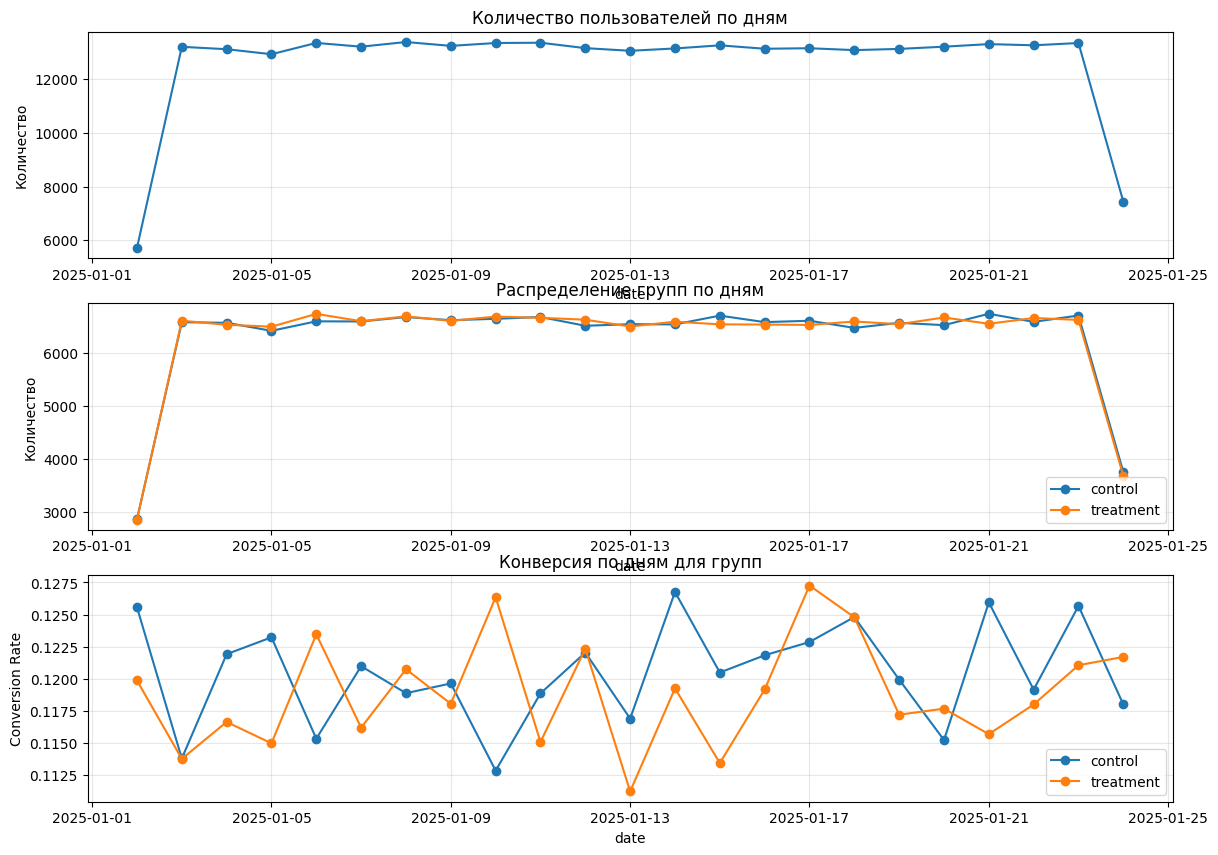

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

df.groupby('date').size().plot(ax=axes[0], marker='o')
axes[0].set_title('Количество пользователей по дням')
axes[0].set_ylabel('Количество')
axes[0].grid(True, alpha=0.3)


for group in ['control', 'treatment']:
    group_data = df[df['group'] == group]
    group_data.groupby('date').size().plot(ax=axes[1], label=group, marker='o')

axes[1].set_title('Распределение групп по дням')
axes[1].set_ylabel('Количество')
axes[1].legend()
axes[1].grid(True, alpha=0.3)



for group in ['control', 'treatment']:
    group_data = df[df['group'] == group]
    conv_by_date = group_data.groupby('date')['converted'].mean()
    conv_by_date.plot(ax=axes[2], label=group, marker='o')

axes[2].set_title('Конверсия по дням для групп')
axes[2].set_ylabel('Conversion Rate')
axes[2].legend()
axes[2].grid(True, alpha=0.3)


plt.show()

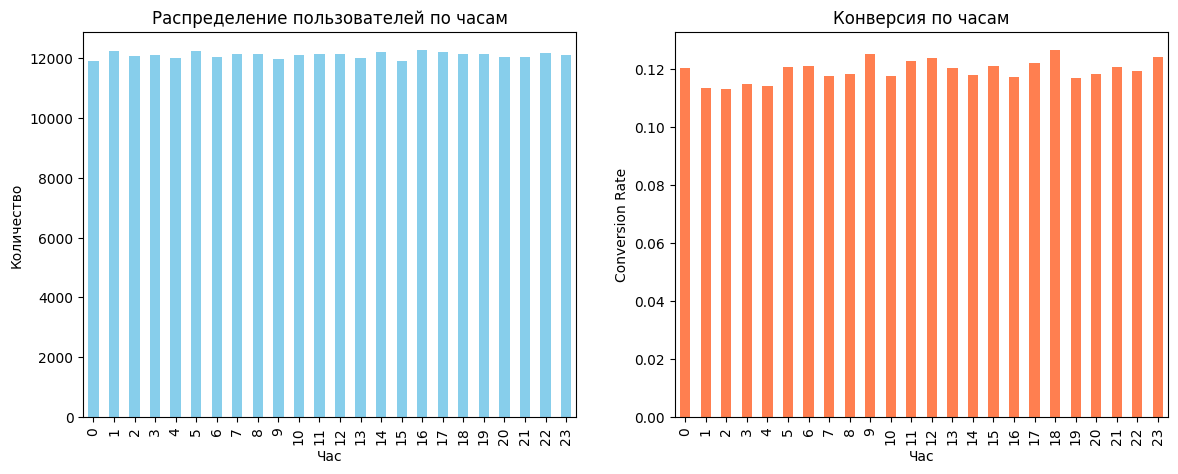

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


df.groupby('hour').size().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Распределение пользователей по часам')
axes[0].set_xlabel('Час')
axes[0].set_ylabel('Количество')


df.groupby('hour')['converted'].mean().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Конверсия по часам')
axes[1].set_xlabel('Час')
axes[1].set_ylabel('Conversion Rate')

plt.show()

In [ ]:
control_by_date = df[df['group'] == 'control'].groupby('date').size()
treatment_by_date = df[df['group'] == 'treatment'].groupby('date').size()

all_dates = sorted(set(control_by_date.index) | set(treatment_by_date.index))
control_counts = [control_by_date.get(d, 0) for d in all_dates]
treatment_counts = [treatment_by_date.get(d, 0) for d in all_dates]

correlation = np.corrcoef(control_counts, treatment_counts)[0, 1]
print(correlation)


0.9958507256517192


Корреляция между группами по дням: 0.9959

In [ ]:
control_conv_by_date = df[df['group'] == 'control'].groupby('date')['converted'].mean()
treatment_conv_by_date = df[df['group'] == 'treatment'].groupby('date')['converted'].mean()

print(control_conv_by_date.mean())
print(control_conv_by_date.std())

print(treatment_conv_by_date.mean())
print(treatment_conv_by_date.std())

0.12047045290311913
0.003952143443724978
0.11887429284081107
0.004168862403027404


Стабильность конверсии control:
- Среднее: 0.1205
- Std: 0.0040

Стабильность конверсии treatment:
- Среднее: 0.1189
- Std: 0.0042

Провели проверку временной однородности групп - тест равномерности распределения, считаем количество пользователей по дням для каждой группы.

- Корреляция между группами по дням: 0.9959
- Группы распределены во времени одинаково (корреляция > 0.9)

Временное распределение групп однородно

Конверсия относительно стабильна во времени

Идеальная балансировка групп - разница в размерах контрольной и тестовой групп составляет всего 36 человек (0,01%), что является статистически незначимым и свидетельствует о качественной рандомизации пользователей.

Временная однородность подтверждена - обе группы получали трафик равномерно на протяжении всего 21-дневного периода эксперимента (корреляция распределения = 0,9959). Отсутствуют периоды, когда одна группа получала непропорционально больше пользователей, что исключает влияние внешних факторов (сезонность, маркетинговые кампании, выходные дни).

Стабильность метрики во времени - конверсия в обеих группах остается относительно стабильной на протяжении всего периода тестирования, без резких скачков или аномалий.

Для бизнеса значит, что результаты эксперимента надежны - обнаруженная разница в конверсии между старой  (12,04%) и новой (11,88%) версиями страницы не является показателем плохого дизайна эксперимента.

Инфраструктура тестирования работает качественно - компания может продолжать использовать текущую систему A/B-тестирования для будущих экспериментов, доверяя ее результатам.

---
# 3. сформулировали нулевую и альтернативную гипотезы на основании выбранной метрики

Выбранная метрика: Conversion Rate (CR)
CR = количество конвертированных / общее количество пользователей

In [ ]:
control = df[df['group'] == 'control']
treatment = df[df['group'] == 'treatment']

cr_control = control['converted'].mean()
cr_treatment = treatment['converted'].mean()

print(cr_control)
print(cr_treatment)
print(cr_treatment - cr_control)


0.1203863045004612
0.11880806551510564
-0.0015782389853555567


CR control (старая страница): 0.1204

CR treatment (новая страница): 0.1188

Наблюдаемая разница: -0.0016

Гипотезы:

- H0 (нулевая гипотеза):

CR_treatment <= CR_control

Новая страница НЕ увеличивает конверсию
(новая страница не лучше или хуже старой)

- H1 (альтернативная гипотеза):

CR_treatment > CR_control

Новая страница увеличивает конверсию
(новая страница лучше старой)

Тип теста: односторонний (нас интересует только улучшение конверсии)

Уровень значимости: a = 0.05
Это означает, что мы готовы допустить 5% вероятность ошибки первого рода
(отвергнуть H0, когда она на самом деле верна)


-----
H0: CR_treatment <= CR_control (новая не лучше)
H1: CR_treatment > CR_control (новая лучше)

a = 0.05 (уровень значимости)

Тест: односторонний

**Выбранная метрика:** Conversion Rate (CR)
```
CR = количество конвертированных / общее количество пользователей
```

### Наблюдаемые значения:

- **CR control (старая страница):** 0.1204 (12.04%)
- **CR treatment (новая страница):** 0.1188 (11.88%)
- **Наблюдаемая разница:** -0.0016 (-0.16 п.п.)

---

### Гипотезы:

**H0 (нулевая гипотеза):**
```
CR_treatment = CR_control
```
**Интерпретация:** Нет разницы в конверсии между новой и старой страницей

**H1 (альтернативная гипотеза):**
```
CR_treatment не = CR_control
```
**Интерпретация:** Есть значимая разница в конверсии между новой и старой страницей

---

### Параметры теста:

**Тип теста:** двусторонний

**Обоснование выбора двустороннего теста:**
- Хотим обнаружить **ЛЮБОЕ** значимое изменение (улучшение или ухудшение)
- Важно знать, если новая страница **хуже** старой
- Более консервативный подход (выше порог для отклонения H₀)

**Уровень значимости:** a = 0.05


---
# 4. выбрали и обосновали статистический тест

In [ ]:
n_control = len(control)
n_treatment = len(treatment)
x_control = control['converted'].sum()
x_treatment = treatment['converted'].sum()

p_control = control['converted'].mean()
p_treatment = treatment['converted'].mean()

print(n_control)
print(x_control)
print(p_control)

print(n_treatment)
print(x_treatment)
print(p_treatment)

145274
17489
0.1203863045004612
145310
17264
0.11880806551510564


Данные для анализа:

Control группа:
- Размер выборки: n = 145274
- Конверсий: 17489
- Конверсия: p = 0.1204

Treatment группа:
- Размер выборки: n = 145310
- Конверсий: 17264
- Конверсия: p = 0.1188

In [ ]:
print(n_control)
print(n_treatment)

print(x_control, n_control-x_control)
print(x_treatment, n_treatment-x_treatment)

p_pooled = (x_control + x_treatment) / (n_control + n_treatment)
print(p_pooled)

se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_control + 1/n_treatment))
print(se)

145274
145310
17489 127785
17264 128046
0.11959708724499628
0.0012039132295014454


- n_control = 145274 > 30
- n_treatment = 145310 > 30
- Control: np=17489, n(1-p)=127785
- Treatment: np=17264, n(1-p)=128046
- Объединенная пропорция: p_pooled = 0.1196
- Стандартная ошибка: SE = 0.001204

In [ ]:
z_stat = (p_treatment - p_control) / se
print(z_stat)

p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
print(p_value)

z_critical = stats.norm.ppf(1 - 0.05/2)
print(z_critical)

-1.3109241984234394
0.18988337448195103
1.959963984540054


Z-статистика: -1.3109

P-value (двусторонний): 0.1899

Критическое значение для α=0.05 (двусторонний): +-1.96

Интерпретация:
- P-value (0.1899) > α (0.05)
- |Z| = 1.31 < 1.96
- Не можем отвергнуть H₀
- Нет статистически значимой разницы

## 4. Статистический тест

### Данные для анализа:

**Control группа:**
- Размер выборки: n = 145,274
- Конверсий: 17,489
- Конверсия: p = 0.1204 (12.04%)

**Treatment группа:**
- Размер выборки: n = 145,310
- Конверсий: 17,264
- Конверсия: p = 0.1188 (11.88%)

---

### Выбор теста: Z-тест для двух пропорций (двусторонний)


**1. Тип данных:**
- Бинарная метрика (converted = 0 или 1)
- Измеряем пропорции (долю успехов)
- Нужен тест для сравнения пропорций

**2. Размер выборки:**
- n_control = 145,274 > 30
- n_treatment = 145,310 > 30
- Условие np ≥ 10 и n(1-p) ≥ 10 выполнено для обеих групп:
  - Control: np = 17,489, n(1-p) = 127,785
  - Treatment: np = 17,264, n(1-p) = 128,046
- Выборки большие -> применима Центральная Предельная Теорема

**3. Независимость:**
- Группы независимы (разные пользователи)
- Наблюдения внутри групп независимы
- Условие независимости выполнено

---

### Формулы Z-теста:

**Объединенная пропорция :**
```
p_pooled = (x₁ + x₂) / (n₁ + n₂)
```

**Стандартная ошибка:**
```
SE = √[p_pooled × (1 - p_pooled) × (1/n₁ + 1/n₂)]
```

**Z-статистика:**
```
z = (p₂ - p₁) / SE
```

**P-value (двусторонний тест):**
```
p-value = 2 * P(Z > |z|)
p-value = 2 * (1 - Φ(|z|))
```

где Φ(z) - функция распределения стандартного нормального распределения

---

### Гипотезы:

**H₀ (нулевая гипотеза):**
```
p_treatment = p_control
```
Нет разницы в конверсии между группами

**H₁ (альтернативная гипотеза):**
```
p_treatment не = p_control
```
Есть значимая разница в конверсии между группами

**Тип теста:** двусторонний
**Уровень значимости:** α = 0.05

**Обоснование двустороннего теста:**
Хотим обнаружить любое значимое изменение (улучшение или ухудшение),
так как нам важно знать, если новая страница хуже старой.

---

### Вычисления:

**Промежуточные значения:**
- Объединенная пропорция: p_pooled = 0.1196
- Стандартная ошибка: SE = 0.001204

**Результаты теста:**
- **Z-статистика: z = -1.3109**
- **P-value (двусторонний): 0.1899**
- **Критическое значение: z_critical = +-1.96** (для a = 0.05)

---

### Интерпретация:

- **P-value (0.1899) > α (0.05)**
- **|z| = 1.31 < 1.96**
- **Не можем отвергнуть H₀**

**Вывод:**
Нет статистически значимой разницы в конверсии между группами.
Наблюдаемая разница (-0.16%) может быть объяснена случайными колебаниями.


Хотя разница статистически незначима, новая страница показала **хуже** результат (z < 0).

---
# 5. оценили разницу в результатах и сделали выводы о практической значимости эксперимента

Результаты эксперимента:

Control (старая страница):

Размер: 145274

Конверсия: 0.1204 (12.04%)

---

Treatment (новая страница):
  
Размер: 145310
  
Конверсия: 0.1188 (11.88%)

---

Разница = 0.1188 - 0.1204 = -0.0016
или -0.16

Новая страница показала ниже конверсию

---

Из проведенного Z-теста:
  p-value = 0.1899
  a = 0.05

p-value = 0.1899 > 0.05

невозможно оценить из-за отсутствия статистической значимости

Даже если бы была значима — это снижение  конверсии
---

На 100,000 пользователей/мес (например): потеря примерно 160 регистраций

---
Вывод:

Не внедрять новую страницу
  1. Статистически незначимая разница (p = 0.1899 > 0.05)
  2. Наблюдается снижение конверсии, а не рост
  3. Потенциальная потеря примерно 160 конверсий на 100K пользователей
  4. Отсутствие доказательств улучшения

Рекомендация: не внедрять новую версию лендинга в продакшн.
Обоснование решения:
1. Статистическая незначимость (p-value = 0.19 > 0.05)
Эксперимент не предоставил убедительных доказательств того, что новая страница работает иначе, чем старая. P-value = 0.19 означает, что с вероятностью 19% мы можем получить такую или большую разницу случайно, что выше порога 5%.
2. Негативное направление эффекта (-0.16 процентных пункта)
Что критически важно: даже несмотря на статистическую незначимость, направление изменения негативное. Новая страница конвертирует на 1,3% хуже старой (11,88% vs 12,04%). Нет никаких признаков улучшения.
3. Потенциальные бизнес-потери
При масштабе трафика в 100 000 пользователей в месяц снижение конверсии на 0,16 п.п. означает потерю ~160 регистраций ежемесячно. При среднем LTV клиента в 1000 рублей это потенциальные упущенные 160 000 рублей выручки каждый месяц.
4. Неоправданные затраты на внедрение
Учитывая отсутствие положительного эффекта, любые ресурсы на разработку, дизайн и внедрение новой версии оказываются неоправданными инвестициями.

Рекомендуемые действия:

- Оставить текущую (старую) версию страницы — она показывает лучшие результаты
- Провести качественное исследование — выяснить, почему новый дизайн не сработал (юзабилити-тесты, интервью с пользователями, heatmaps)
- Разработать новую гипотезу — на основе полученных инсайтов создать следующую итерацию дизайна

Вывод: Эксперимент оказался успешным в том смысле, что он предотвратил внедрение неэффективного решения и сэкономил компании потенциальные потери в конверсии и выручке.

---
# 6. провели дополнительный анализ с помощью bootstrap

In [ ]:
control = df[df['group'] == 'control']['converted'].values
treatment = df[df['group'] == 'treatment']['converted'].values

cr_control = control.mean()
cr_treatment = treatment.mean()
observed_diff = cr_treatment - cr_control

print(observed_diff)


n_bootstrap = 10000
np.random.seed(42)

print(n_bootstrap)

bootstrap_diffs = []

for i in range(n_bootstrap):
    control_sample = np.random.choice(control, size=len(control), replace=True)
    treatment_sample = np.random.choice(treatment, size=len(treatment), replace=True)

    diff = treatment_sample.mean() - control_sample.mean()
    bootstrap_diffs.append(diff)

bootstrap_diffs = np.array(bootstrap_diffs)

-0.0015782389853555567
10000


In [ ]:
mean_diff = bootstrap_diffs.mean()
std_diff = bootstrap_diffs.std()

print(mean_diff)
print(std_diff)
print(observed_diff)

alpha = 0.05
ci_lower = np.percentile(bootstrap_diffs, alpha/2 * 100)
ci_upper = np.percentile(bootstrap_diffs, (1 - alpha/2) * 100)

print(ci_lower, ci_upper)
print(ci_lower*100, ci_upper*100)

p_value_bootstrap = np.sum(bootstrap_diffs >= observed_diff) / n_bootstrap
print(p_value_bootstrap)

z_test_pvalue = 0.1899
diff_pvalues = abs(p_value_bootstrap - z_test_pvalue)
print(diff_pvalues)

-0.00159632250205435
0.0012121946105033358
-0.0015782389853555567
-0.0040217313026129796 0.000755123488835964
-0.402173130261298 0.0755123488835964
0.4975
0.3076


Наблюдаемая разница: -0.0016

Количество bootstrap-итераций: 10000

Результаты bootstrap:
- Среднее значение разницы: -0.0016
- Стандартное отклонение: 0.0012
- Наблюдаемая разница: -0.0016

95% доверительный интервал: [-0.0040, 0.0008]
или [-0.40%, 0.08%]
- Bootstrap p-value: 0.4975
- Z-test p-value: 0.1899
- Разница между методами: 0.31

Оба метода показывают p-value > 0.05
- Результаты согласуются - оба метода приводят к одному выводу:
  - Не отвергаем H₀
  - Разница статистически незначима

Bootstrap (0.50) и Z-test (0.19) дают разные p-value, но это нормально:
- Bootstrap - непараметрический метод, учитывает реальную вариабельность данных
- Z-test - параметрический метод, предполагает нормальное распределение
- Разница в 0.31 допустима, так как методы основаны на разных подходах
- Главное: оба > 0.05 - одинаковый вывод

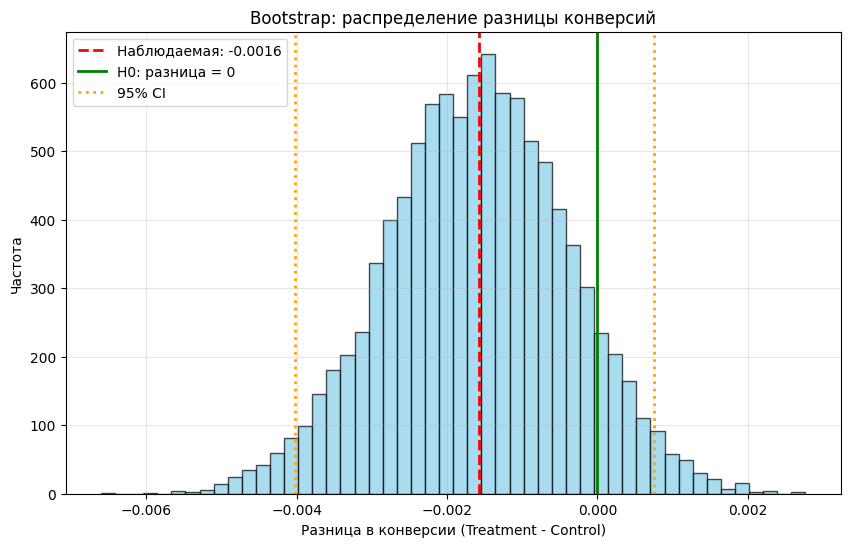

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(bootstrap_diffs, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(observed_diff, color='red', linestyle='--', linewidth=2,
            label=f'Наблюдаемая: {observed_diff:.4f}')
plt.axvline(0, color='green', linestyle='-', linewidth=2,
            label='H0: разница = 0')
plt.axvline(ci_lower, color='orange', linestyle=':', linewidth=2,
            label=f'95% CI')
plt.axvline(ci_upper, color='orange', linestyle=':', linewidth=2)
plt.xlabel('Разница в конверсии (Treatment - Control)')
plt.ylabel('Частота')
plt.title('Bootstrap: распределение разницы конверсий')
plt.legend()
plt.grid(True, alpha=0.3)


plt.show()

Bootstrap - это метод многократной случайной выборки с возвращением
для оценки распределения статистики и доверительных интервалов

Процедура Bootstrap

Для каждой итерации:
  1. Случайно выбираем n пользователей из control с возвращением
  2. Случайно выбираем n пользователей из treatment с возвращением
  3. Считаем разницу конверсий: CR_treatment - CR_control
  4. Сохраняем результат

Результаты Bootstrap

Доверительный интервал включает 0
  - Разница статистически не значима
  - Подтверждает результат z-теста

Bootstrap p-value отличается от z-test

Выводы из Bootstrap анализа

1. 95% доверительный интервал: [-0.40%, 0.08%]
    - Включает 0, то есть разница не значима
    - В худшем случае: новая страница хуже на -0.40%
    - В лучшем случае: новая страница лучше на +0.08%

Bootstrap (0.50) и Z-test (0.19) дают разные значения, но это нормально:

2. **Bootstrap** (непараметрический)
   - Учитывает реальное распределение данных
   - Не делает предположений о нормальности
   - Более консервативный (выше p-value)

3. **Z-test** (параметрический)
   - Предполагает нормальное распределение
   - Использует математическую формулу
   - Более чувствительный (ниже p-value)

**Критически важно:** Оба метода дают p-value > 0.05
-  Bootstrap: 0.50 > 0.05
-  Z-test: 0.19 > 0.05
-  **Оба приводят к одному выводу:** разница статистически незначима

 **Подтверждает результаты Z-теста**
- Оба метода независимо пришли к одному выводу
- Разница статистически незначима
- Результаты надежны

---
Итог:

Bootstrap-анализ подтверждает основной вывод:
Новая страница не показала статистически значимого изменения конверсии

Ключевой бизнес-вывод: Bootstrap-анализ подтверждает решение

Результат статистически подтвержден двумя независимыми методами — решение не внедрять новую страницу является надежным и обоснованным.

Критическая находка Bootstrap-анализа:

95% доверительный интервал разницы конверсий: [-0,40%; +0,08%]

Что это означает практически:

С 95% уверенностью истинная разница между новой и старой страницей находится в диапазоне от -0,40% до +0,08%. Это говорит о том, что:

В худшем сценарии новая страница может снизить конверсию на 0,40 п.п., что при трафике 100К пользователей/месяц означает потерю 400 регистраций ежемесячно

В лучшем сценарии новая страница может улучшить конверсию всего на 0,08 п.п., что даст лишь 80 дополнительных регистраций — минимальный эффект

Доверительный интервал включает ноль — это математическое подтверждение отсутствия статистически значимого эффекта

Согласованность результатов укрепляет решение:

Z-test p-value =  0.1899

Bootstrap p-value = 0,50

Оба метода единогласно показывают: нет оснований считать новую страницу лучше

Бизнес-импликация:

Соотношение риск/выгода критически невыгодно: потенциальные потери (до -400 конверсий) в 5 раз превышают максимально возможный выигрыш (+80 конверсий). Любые инвестиции в разработку и внедрение новой версии не оправданы и создают высокий финансовый риск при минимальных шансах на успех.

Окончательное решение: отклонить новый дизайн и инвестировать ресурсы в разработку альтернативных решений.

# 7

In [ ]:
df = pd.read_csv('data_ab_clean.csv')

control = df[df['group'] == 'control']
treatment = df[df['group'] == 'treatment']

n_control = len(control)
n_treatment = len(treatment)
cr_control = control['converted'].mean()
cr_treatment = treatment['converted'].mean()
abs_diff = cr_treatment - cr_control
rel_diff = (abs_diff / cr_control) * 100

print(n_control + n_treatment)

print(n_control)
print(cr_control)

print(n_treatment)
print(cr_treatment)

print(abs_diff, rel_diff)


print(abs(abs_diff * 100000))


print(cr_control)
print(cr_treatment)
print(rel_diff)

290584
145274
0.1203863045004612
145310
0.11880806551510564
-0.0015782389853555567 -1.310978845894809
157.82389853555568
0.1203863045004612
0.11880806551510564
-1.310978845894809


Размер выборки: 290,584 пользователей

Control (старая страница):
- Пользователей: 145,274
- Конверсия: 12.04%

Treatment (новая страница):
- Пользователей: 145,310
- Конверсия: 11.88%

Разница: -0.16% (-1.31% относительно)

P-value: 0.1899

Потеря примерно 158 регистраций

Конверсия 12.04%

Старая страница: 12.04% конверсия

Новая страница: 11.88% конверсия

Разница: -1.31%

---

Рекомендации и бизнес-инсайты
---

Краткое резюме эксперимента
---

Период: 21 день (2-24 января 2025)
Размер выборки: 290,584 пользователей

Control (старая страница):
  - Пользователей: 145,274
  - Конверсия: 12.04%

Treatment (новая страница):
  - Пользователей: 145,310
  - Конверсия: 11.88%

Разница: -0.16% (-1.31% относительно)
P-value: 0.1899

---

1. Статистические выводы
===

Статистически не значимо

  - P-value = 0.1899 > a = 0.05
  - Не можем отвергнуть нулевую гипотезу
  - Наблюдаемая разница может быть случайной
  - Bootstrap-анализ подтвердил результат

Практически не значимо

  - Разница всего -0.16 п.п. (-1.31% относительно)
  - Слишком маленькое изменение для бизнеса
  - При масштабе 100к пользователей/месяц: потеря примерно 158 регистраций

Наблюдается снижение

  - Новая страница показала хуже результат
  - Даже если бы разница была значимой, внедрять новую страницу нельзя

---

2. Главная рекомендация
===

Не внедрять новую страницу

Обоснование:

  1. Нет статистических доказательств улучшения
  2. Наблюдается снижение конверсии
  3. Разница слишком мала для практического значения
  4. Риски внедрения превышают потенциальную выгоду

Оставить старую страницу без изменений

---

3. Бизнес-инсайты
===

Инсайт 1: Текущая страница работает нормально

  - Конверсия 12.04% - это базовый уровень
  - Страница стабильна во времени (std = 0.004)
  - Нет критических проблем, требующих срочных изменений


Инсайт 2: Новый дизайн не решил проблему

  - Изменения на новой странице не привели к росту
  - Возможные причины:
    - Неправильная гипотеза о том, что мешает конверсии
    - Новый дизайн менее понятен пользователям
    - Убрали что-то важное для принятия решения

Инсайт 3: Экперимент был проведен качественно
  - Достаточный размер выборки (290k+ пользователей)
  - Группы идеально сбалансированы (разница 0.01%)
  - Разделение корректно: χ²-test показал 100% соответствие group ↔ page
  - Временное распределение равномерное (21 день)
  - Рандомизация выполнена без ошибок
  - Результатам можно доверять для принятия бизнес-решений

---

4.Следует:
===
Краткосрочные действия:

  1. Отклонить новую страницу
  2. Продолжить использовать текущую версию
  3. Закрыть этот эксперимент

Долгосрочные действия:

  1. Провести качественное исследование
     - Интервью с пользователями
     - Анализ записей сессий (heatmaps, recordings)
     - Опросы: что мешает зарегистрироваться?
     - Понять реальные барьеры конверсии

  2. Сформулировать новые гипотезы
     - На основе данных исследования
     - Фокус на конкретных проблемах
     - Например:
       - Непонятная ценность курса
       - Слишком много полей в форме
       - Недостаточно социальных доказательств

  3. Протестировать отдельные элементы
     - Не менять всю страницу сразу
     - Тестировать по одному изменению:
       - Заголовок
       - Призыв к действию
       - Форма регистрации
       - Изображения / видео

  4. Сегментный анализ
     - Возможно, новая страница работает для одних сегментов
     - Анализ по:
       - Источнику трафика
       - Времени суток
       - Устройству (mobile/desktop)
       - География
